<a href="https://colab.research.google.com/github/SafwanHasan/Stock-Prediction-Model/blob/dev/Copy_of_WORKING_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sp500 = pd.read_csv("/content/drive/MyDrive/Advanced NLP/Assignments/Assignment_2/CSV_Files/Stock_Data/sp500_stock_price_01_01_2010-01_12_2024/sp500_index.csv")

In [ ]:
sp500

,Date,S&P500
0,2014-12-22,2078.54
1,2014-12-23,2082.17
2,2014-12-24,2081.88
3,2014-12-26,2088.77
4,2014-12-29,2090.57
...,...,...
2512,2024-12-16,6074.08
2513,2024-12-17,6050.61
2514,2024-12-18,5872.16
2515,2024-12-19,5867.08


In [ ]:
fred = pd.read_csv("/content/fredgraph.csv")

In [ ]:
fred

,observation_date,MEDCPIM158SFRBCLE,EFFR
0,2001-01-01,4.076478,6.02
1,2001-02-01,2.836789,5.51
2,2001-03-01,2.992147,5.32
3,2001-04-01,3.144633,4.81
4,2001-05-01,3.501116,4.23
...,...,...,...
285,2024-10-01,3.698695,4.83
286,2024-11-01,3.226070,4.65
287,2024-12-01,3.234511,4.48
288,2025-01-01,3.930193,4.33


In [ ]:
# Convert Date column to datetime
sp500['Date'] = pd.to_datetime(sp500['Date'])

# Set Date column as index
sp500.set_index('Date', inplace=True)

# Resample to monthly frequency using the first available value in each month
sp500_monthly = sp500.resample('MS').first().reset_index()  # 'MS' gives the first day of the month

print(sp500_monthly.head())

        Date   S&P500
0 2014-12-01  2078.54
1 2015-01-01  2058.20
2 2015-02-01  2020.85
3 2015-03-01  2117.39
4 2015-04-01  2059.69


In [ ]:
# Convert the observation_date column in CPI/EFFR data to datetime
fred['observation_date'] = pd.to_datetime(fred['observation_date'])

# Merge S&P 500 data with CPI and EFFR on the date column
merged_data = sp500_monthly.merge(
    fred, left_on='Date', right_on='observation_date', how='inner'
)

# Drop the duplicate observation_date column
merged_data.drop(columns=['observation_date'], inplace=True)


In [ ]:
fred.head()

,observation_date,MEDCPIM158SFRBCLE,EFFR
0,2001-01-01,4.076478,6.02
1,2001-02-01,2.836789,5.51
2,2001-03-01,2.992147,5.32
3,2001-04-01,3.144633,4.81
4,2001-05-01,3.501116,4.23


In [ ]:
merged_data

,Date,S&P500,MEDCPIM158SFRBCLE,EFFR
0,2014-12-01,2078.54,2.383394,0.12
1,2015-01-01,2058.20,1.947530,0.12
2,2015-02-01,2020.85,1.954495,0.11
3,2015-03-01,2117.39,2.433336,0.11
4,2015-04-01,2059.69,2.962651,0.12
...,...,...,...,...
116,2024-08-01,5446.68,3.701742,5.33
117,2024-09-01,5528.93,4.146461,5.13
118,2024-10-01,5708.75,3.698695,4.83
119,2024-11-01,5728.80,3.226070,4.65


In [ ]:

# Compute correlation matrix
correlation_matrix = merged_data[['S&P500', 'MEDCPIM158SFRBCLE', 'EFFR']].corr()

print(correlation_matrix)


                     S&P500  MEDCPIM158SFRBCLE      EFFR
S&P500             1.000000           0.538584  0.624137
MEDCPIM158SFRBCLE  0.538584           1.000000  0.339457
EFFR               0.624137           0.339457  1.000000


In [ ]:
import pandas as pd
import statsmodels.api as sm

# Ensure data is merged and clean
merged_data = merged_data.dropna()  # Drop any missing values

# Define independent variables (CPI and EFFR)
X = merged_data[['MEDCPIM158SFRBCLE', 'EFFR']]

# Add constant for intercept
X = sm.add_constant(X)

# Define dependent variable (S&P 500)
y = merged_data['S&P500']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 S&P500   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     61.46
Date:                Tue, 25 Mar 2025   Prob (F-statistic):           5.15e-19
Time:                        19:03:32   Log-Likelihood:                -972.74
No. Observations:                 121   AIC:                             1951.
Df Residuals:                     118   BIC:                             1960.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1974.5710    163.85

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [ ]:
# Sort the data by the date column to ensure temporal order
merged_data = merged_data.sort_values('Date')

# Set the split date for the training and test set (e.g., using 80% for training and 20% for testing)
split_date = '2021-01-01'

# Split the data based on the date
train_data = merged_data[merged_data['Date'] < split_date]
test_data = merged_data[merged_data['Date'] >= split_date]

# Prepare the features (X) and target (y) for training and testing
X_train = train_data[['MEDCPIM158SFRBCLE', 'EFFR']]
y_train = train_data['S&P500']
X_test = test_data[['MEDCPIM158SFRBCLE', 'EFFR']]
y_test = test_data['S&P500']

# Feature scaling (important for some ML models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

# Print the evaluation metrics
print(f"R-squared: {r2}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")


R-squared: -8.417228509334524
Mean Absolute Error: 1667.4802604166673
Root Mean Squared Error: 3193232.5909816097


In [ ]:
merged_data

,Date,S&P500,MEDCPIM158SFRBCLE,EFFR
0,2014-12-01,2078.54,2.383394,0.12
1,2015-01-01,2058.20,1.947530,0.12
2,2015-02-01,2020.85,1.954495,0.11
3,2015-03-01,2117.39,2.433336,0.11
4,2015-04-01,2059.69,2.962651,0.12
...,...,...,...,...
116,2024-08-01,5446.68,3.701742,5.33
117,2024-09-01,5528.93,4.146461,5.13
118,2024-10-01,5708.75,3.698695,4.83
119,2024-11-01,5728.80,3.226070,4.65


In [ ]:
merged_data.head()

,Date,S&P500,MEDCPIM158SFRBCLE,EFFR
0,2014-12-01,2078.54,2.383394,0.12
1,2015-01-01,2058.20,1.947530,0.12
2,2015-02-01,2020.85,1.954495,0.11
3,2015-03-01,2117.39,2.433336,0.11
4,2015-04-01,2059.69,2.962651,0.12


In [ ]:
merged_data

,Date,S&P500,MEDCPIM158SFRBCLE,EFFR
0,2014-12-01,2078.54,2.383394,0.12
1,2015-01-01,2058.20,1.947530,0.12
2,2015-02-01,2020.85,1.954495,0.11
3,2015-03-01,2117.39,2.433336,0.11
4,2015-04-01,2059.69,2.962651,0.12
...,...,...,...,...
116,2024-08-01,5446.68,3.701742,5.33
117,2024-09-01,5528.93,4.146461,5.13
118,2024-10-01,5708.75,3.698695,4.83
119,2024-11-01,5728.80,3.226070,4.65


In [ ]:
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# Assuming 'merged_data' is your dataset
features = ['S&P500', 'MEDCPIM158SFRBCLE', 'EFFR']  # Replace with your actual columns

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit and transform the data (normalize)
merged_data[features] = scaler.fit_transform(merged_data[features])

# Verify the result
print(merged_data.head())


        Date    S&P500  MEDCPIM158SFRBCLE      EFFR
0 2014-12-01  0.039845           0.175821  0.013258
1 2015-01-01  0.034924           0.113972  0.013258
2 2015-02-01  0.025887           0.114961  0.011364
3 2015-03-01  0.049244           0.182908  0.011364
4 2015-04-01  0.035284           0.258018  0.013258


In [ ]:
import numpy as np
import pandas as pd

# Assuming merged_data is your dataframe
# Set the number of months for your LSTM window (12 months)
time_window = 12

# Normalize the 'Date' column to ensure sequential ordering
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Sort data by date
merged_data = merged_data.sort_values('Date')

# Drop the 'Date' column since it's not needed for LSTM inputs
data_values = merged_data.drop('Date', axis=1).values

# Function to create sequences for LSTM
def create_sequences(data, time_window):
    X = []
    y = []
    for i in range(time_window, len(data)):
        X.append(data[i-time_window:i, :])  # past `time_window` months
        y.append(data[i, 0])  # predicting the next month's 'S&P500' value
    return np.array(X), np.array(y)

# Create the training and testing split
train_size = int(len(data_values) * 0.8)  # 80% for training
train_data = data_values[:train_size]
test_data = data_values[train_size:]

# Create sequences for LSTM
X_train, y_train = create_sequences(train_data, time_window)
X_test, y_test = create_sequences(test_data, time_window)

# Verify the shape of X_train and X_test
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (84, 12, 3)
X_test shape: (13, 12, 3)


In [ ]:
X_train

array([[[0.03984468, 0.17582125, 0.01325758],
        [0.03492367, 0.11397218, 0.01325758],
        [0.02588731, 0.1149605 , 0.01136364],
        ...,
        [0.        , 0.26309262, 0.01704545],
        [0.00241212, 0.16159868, 0.01325758],
        [0.0460165 , 0.15908934, 0.01325758]],

       [[0.03492367, 0.11397218, 0.01325758],
        [0.02588731, 0.1149605 , 0.01136364],
        [0.04924395, 0.18290796, 0.01136364],
        ...,
        [0.00241212, 0.16159868, 0.01325758],
        [0.0460165 , 0.15908934, 0.01325758],
        [0.04567295, 0.09796449, 0.03409091]],

       [[0.02588731, 0.1149605 , 0.01136364],
        [0.04924395, 0.18290796, 0.01136364],
        [0.03528416, 0.25801756, 0.01325758],
        ...,
        [0.0460165 , 0.15908934, 0.01325758],
        [0.04567295, 0.09796449, 0.03409091],
        [0.02390584, 0.22194183, 0.05871212]],

       ...,

       [[0.63151477, 0.60069661, 0.00568182],
        [0.59109912, 0.81878376, 0.00568182],
        [0.65318753, 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,851 (42.39 KB)

 Trainable params: 10,851 (42.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.1698 - val_loss: 0.4702
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0756 - val_loss: 0.1940
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0301 - val_loss: 0.0711
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0288 - val_loss: 0.0668
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0199 - val_loss: 0.1353
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0185 - val_loss: 0.2069
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0159 - val_loss: 0.2452
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0157 - val_loss: 0.2353
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0117 - val_loss: 0.2060
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0107 - val_loss: 0.1685
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0077 - val_loss: 0.1463
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0062 - val_loss: 0.1408
E

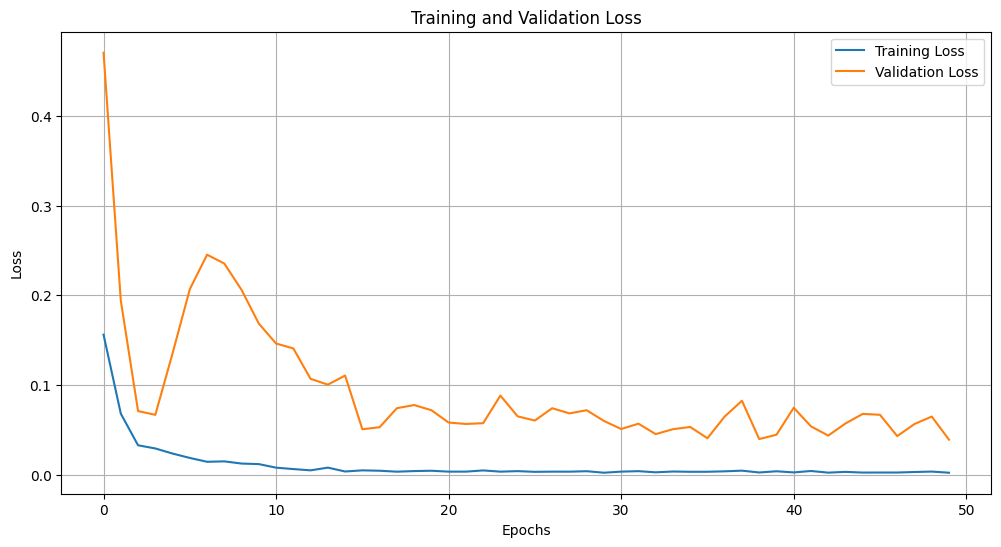

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0392
Test Loss: 0.03917046636343002
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Mean Absolute Error (MAE): 0.1961766055630809
R-Squared (R²): -3.1704321071323758


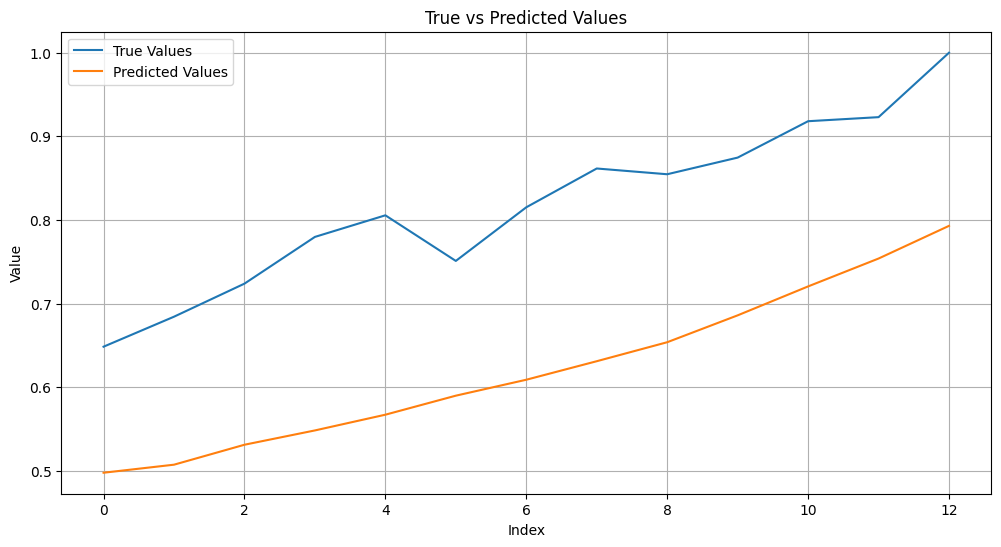

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the LSTM model
model = Sequential()

# LSTM layer with dropout for regularization
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Add dropout layer for regularization

# Dense layer for output
model.add(Dense(units=1))

# Compile the model with Adam optimizer and mean squared error loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Print the model summary
model.summary()

# Train the model and store the history
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Predict the future values (optional)
predictions = model.predict(X_test)

# Calculate additional test metrics: MAE and R²
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Output the test metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-Squared (R²): {r2}")

# Plot True vs Predicted values for visual comparison
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_squared_log_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MSLE
msle = mean_squared_log_error(y_test, predictions)
print(f"Mean Squared Logarithmic Error (MSLE): {msle}")


Root Mean Squared Error (RMSE): 0.2101747850729478
Mean Squared Logarithmic Error (MSLE): 0.015357142228829189


In [ ]:
# Save the model to a file
model.save('sp500_lstm_model.h5')  # You can replace 'sp500_lstm_model.h5' with your desired file name


In [ ]:
# Save the model to a specific path on Google Drive
model.save('/content/drive/MyDrive/models/sp500_lstm_model.h5')

In [ ]:
merged_data

,Date,S&P500,MEDCPIM158SFRBCLE,EFFR
0,2014-12-01,0.039845,0.175821,0.013258
1,2015-01-01,0.034924,0.113972,0.013258
2,2015-02-01,0.025887,0.114961,0.011364
3,2015-03-01,0.049244,0.182908,0.011364
4,2015-04-01,0.035284,0.258018,0.013258
...,...,...,...,...
116,2024-08-01,0.854724,0.362894,1.000000
117,2024-09-01,0.874623,0.426000,0.962121
118,2024-10-01,0.918128,0.362462,0.905303
119,2024-11-01,0.922979,0.295397,0.871212


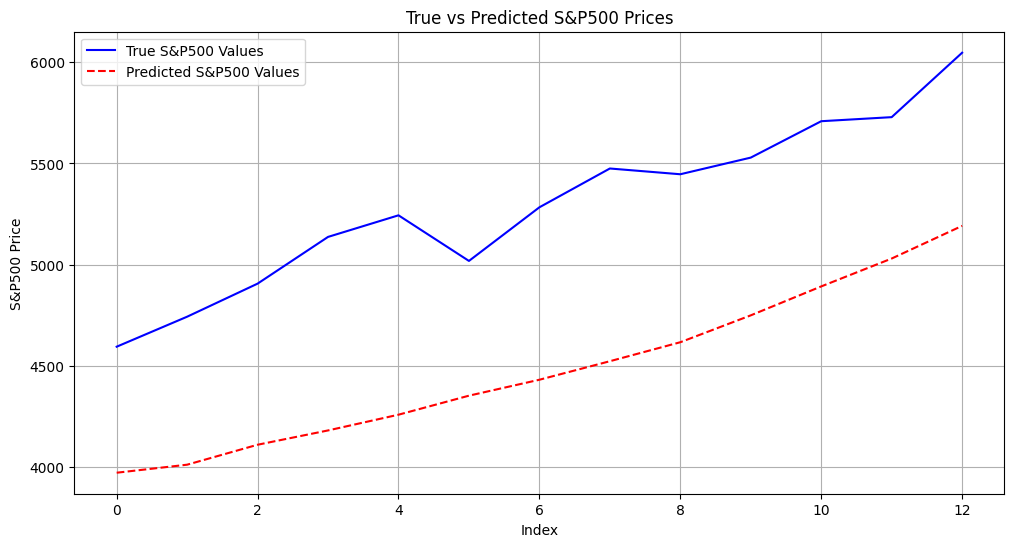

In [ ]:
# Reshape y_test to match the expected shape for inverse transformation
y_test_reshaped = y_test.reshape(-1, 1)

# Create a dummy array for inverse transformation
dummy_y_test = np.zeros((y_test_reshaped.shape[0], data_values.shape[1]))
dummy_y_test[:, 0] = y_test_reshaped[:, 0]  # Fill actual y_test values

# Inverse transform the true y_test values
actual_y_test = scaler.inverse_transform(dummy_y_test)[:, 0]

# Reshape predictions for inverse transformation
predictions_reshaped = predictions.reshape(-1, 1)

# Create a dummy array for inverse transformation
dummy_predictions = np.zeros((predictions_reshaped.shape[0], data_values.shape[1]))
dummy_predictions[:, 0] = predictions_reshaped[:, 0]  # Fill predicted values

# Inverse transform the predicted values
actual_predictions = scaler.inverse_transform(dummy_predictions)[:, 0]

# Plot the actual true values vs. actual predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_y_test, label='True S&P500 Values', color='blue')
plt.plot(actual_predictions, label='Predicted S&P500 Values', color='red', linestyle='dashed')
plt.title('True vs Predicted S&P500 Prices')
plt.xlabel('Index')
plt.ylabel('S&P500 Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
sentiment_data = {
    "Year": list(range(2006, 2024)),  # Extracting years
    "FinBERT_Score": [
        -0.347001, -0.35209, -0.386125, -0.477752, -0.459464, -0.435904, -0.450956,
        -0.454255, -0.456695, -0.455177, -0.456891, -0.442388, -0.443913, -0.442248,
        -0.481045, -0.525172, -0.509144, -0.479101
    ]
}
sentiment_df = pd.DataFrame(sentiment_data)

In [ ]:
# Merge sentiment scores with monthly data
merged_data["Year"] = merged_data["Date"].dt.year  # Extract year

merged_df2 = merged_data.merge(sentiment_df, on='Year', how='left')

In [ ]:
merged_df2

,Date,S&P500,MEDCPIM158SFRBCLE,EFFR,Year,FinBERT_Score
0,2014-12-01,2078.54,2.383394,0.12,2014,-0.456695
1,2015-01-01,2058.20,1.947530,0.12,2015,-0.455177
2,2015-02-01,2020.85,1.954495,0.11,2015,-0.455177
3,2015-03-01,2117.39,2.433336,0.11,2015,-0.455177
4,2015-04-01,2059.69,2.962651,0.12,2015,-0.455177
...,...,...,...,...,...,...
116,2024-08-01,5446.68,3.701742,5.33,2024,NaN
117,2024-09-01,5528.93,4.146461,5.13,2024,NaN
118,2024-10-01,5708.75,3.698695,4.83,2024,NaN
119,2024-11-01,5728.80,3.226070,4.65,2024,NaN


In [ ]:
merged_df2 = merged_df2.dropna()

In [ ]:
merged_df2

,Date,S&P500,MEDCPIM158SFRBCLE,EFFR,Year,FinBERT_Score
0,2014-12-01,2078.54,2.383394,0.12,2014,-0.456695
1,2015-01-01,2058.20,1.947530,0.12,2015,-0.455177
2,2015-02-01,2020.85,1.954495,0.11,2015,-0.455177
3,2015-03-01,2117.39,2.433336,0.11,2015,-0.455177
4,2015-04-01,2059.69,2.962651,0.12,2015,-0.455177
...,...,...,...,...,...,...
104,2023-08-01,4576.73,4.207969,5.33,2023,-0.479101
105,2023-09-01,4515.77,4.838968,5.33,2023,-0.479101
106,2023-10-01,4288.39,4.165763,5.33,2023,-0.479101
107,2023-11-01,4237.86,5.535064,5.33,2023,-0.479101


In [ ]:
merged_df2 = merged_df2.drop("Year", axis=1)

In [ ]:
merged_df2

,Date,S&P500,MEDCPIM158SFRBCLE,EFFR,FinBERT_Score
0,2014-12-01,2078.54,2.383394,0.12,-0.456695
1,2015-01-01,2058.20,1.947530,0.12,-0.455177
2,2015-02-01,2020.85,1.954495,0.11,-0.455177
3,2015-03-01,2117.39,2.433336,0.11,-0.455177
4,2015-04-01,2059.69,2.962651,0.12,-0.455177
...,...,...,...,...,...
104,2023-08-01,4576.73,4.207969,5.33,-0.479101
105,2023-09-01,4515.77,4.838968,5.33,-0.479101
106,2023-10-01,4288.39,4.165763,5.33,-0.479101
107,2023-11-01,4237.86,5.535064,5.33,-0.479101


In [ ]:
merged_df2.to_csv('/content/drive/MyDrive/models/final_dataset.csv')

In [ ]:
merged_data2 = merged_df2

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Assuming 'merged_data2' is your dataset
features = ['S&P500', 'MEDCPIM158SFRBCLE', 'EFFR', 'FinBERT_Score']  # Include 'FinBERT_Score'

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
merged_data2[features] = scaler.fit_transform(merged_data2[features])

# Normalize the 'Date' column to ensure sequential ordering
merged_data2['Date'] = pd.to_datetime(merged_data2['Date'])

# Sort data by date
merged_data2 = merged_data2.sort_values('Date')

# Drop the 'Date' column since it's not needed for LSTM inputs
data_values = merged_data2.drop('Date', axis=1).values

# Function to create sequences for LSTM
def create_sequences(data, time_window):
    X = []
    y = []
    for i in range(time_window, len(data)):
        X.append(data[i-time_window:i, :])  # past `time_window` months
        y.append(data[i, 0])  # predicting the next month's 'S&P500' value
    return np.array(X), np.array(y)

# Set the number of months for your LSTM window (12 months)
time_window = 12

# Create the training and testing split
train_size = int(len(data_values) * 0.8)  # 80% for training
train_data = data_values[:train_size]
test_data = data_values[train_size:]

# Create sequences for LSTM
X_train, y_train = create_sequences(train_data, time_window)
X_test, y_test = create_sequences(test_data, time_window)

# Verify the shape of X_train and X_test
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")



X_train shape: (75, 12, 4)
X_test shape: (10, 12, 4)


In [ ]:
# Define the LSTM model
model = Sequential()

# LSTM layer with dropout for regularization
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Add dropout layer for regularization

# Dense layer for output
model.add(Dense(units=1))

# Compile the model with Adam optimizer and mean squared error loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Print the model summary
model.summary()

# Train the model and store the history
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,051 (43.17 KB)

 Trainable params: 11,051 (43.17 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - loss: 0.2304 - val_loss: 0.3467
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1091 - val_loss: 0.1416
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1000 - val_loss: 0.0888
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0804 - val_loss: 0.0747
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0492 - val_loss: 0.0428
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0207 - val_loss: 0.0065
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0118 - val_loss: 0.0066
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0118 - val_loss: 0.0163
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0114 - val_loss: 0.0165
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0137 - val_loss: 0.0049
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0081 - val_loss: 0.0053
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0069 - val_loss: 0.0070


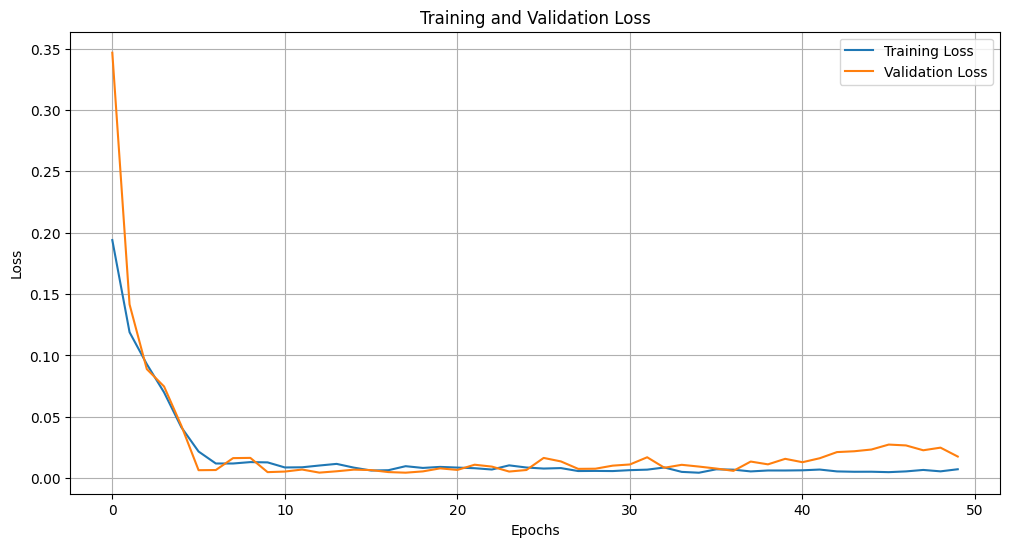

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0176
Test Loss: 0.017583712935447693
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Mean Absolute Error (MAE): 0.11773185142190172
R-Squared (R²): -2.5433567575854155


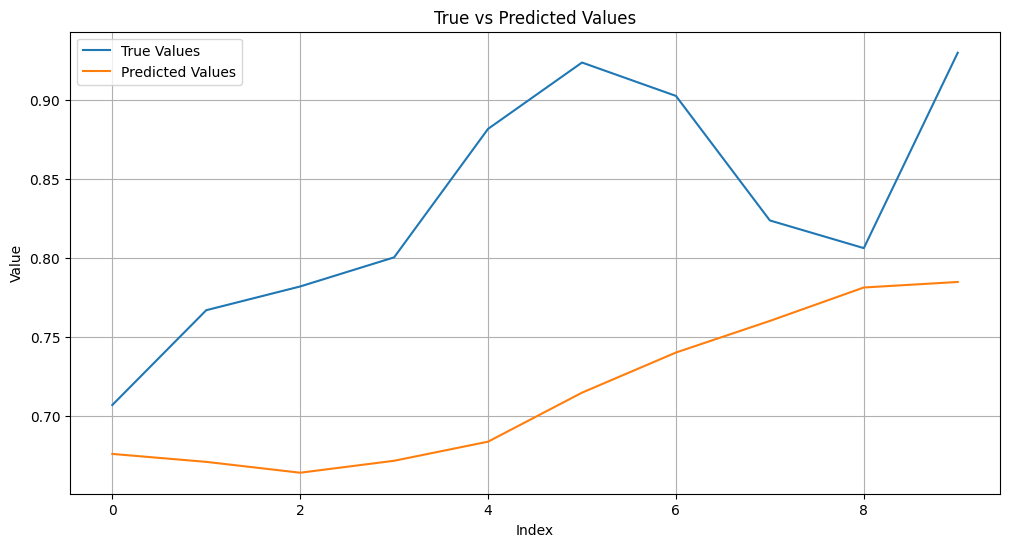

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Predict the future values (optional)
predictions = model.predict(X_test)

# Calculate additional test metrics: MAE and R²
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Output the test metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-Squared (R²): {r2}")

# Plot True vs Predicted values for visual comparison
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


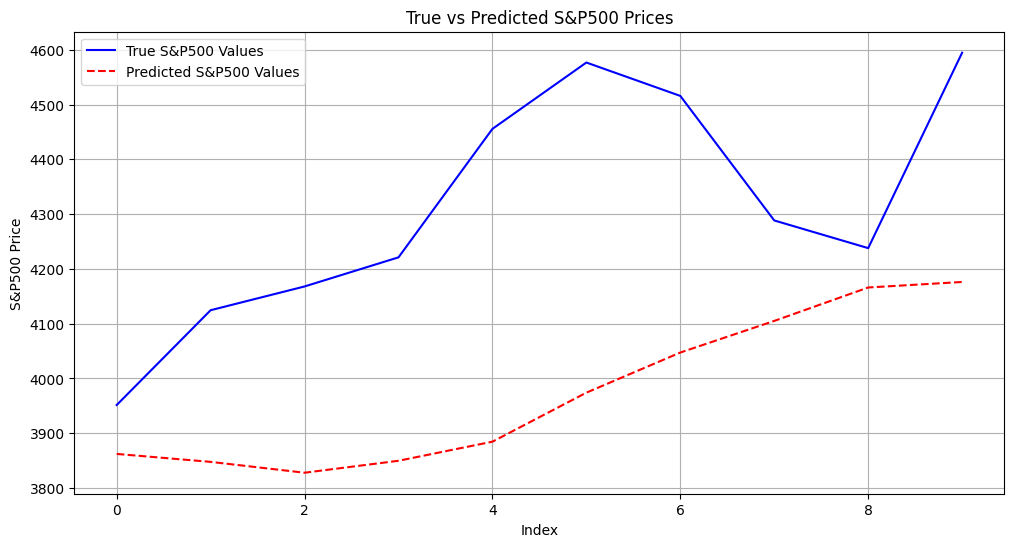

In [ ]:
# Reshape y_test to match the expected shape for inverse transformation
y_test_reshaped = y_test.reshape(-1, 1)

# Create a dummy array for inverse transformation
dummy_y_test = np.zeros((y_test_reshaped.shape[0], data_values.shape[1]))
dummy_y_test[:, 0] = y_test_reshaped[:, 0]  # Fill actual y_test values

# Inverse transform the true y_test values
actual_y_test = scaler.inverse_transform(dummy_y_test)[:, 0]

# Reshape predictions for inverse transformation
predictions_reshaped = predictions.reshape(-1, 1)

# Create a dummy array for inverse transformation
dummy_predictions = np.zeros((predictions_reshaped.shape[0], data_values.shape[1]))
dummy_predictions[:, 0] = predictions_reshaped[:, 0]  # Fill predicted values

# Inverse transform the predicted values
actual_predictions = scaler.inverse_transform(dummy_predictions)[:, 0]

# Plot the actual true values vs. actual predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_y_test, label='True S&P500 Values', color='blue')
plt.plot(actual_predictions, label='Predicted S&P500 Values', color='red', linestyle='dashed')
plt.title('True vs Predicted S&P500 Prices')
plt.xlabel('Index')
plt.ylabel('S&P500 Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Save the model to a file
model.save('/content/drive/MyDrive/models/sp500_lstm_model_with_sent.h5')